In [126]:
import numpy as np, os, sys, matplotlib.pyplot as plt, seaborn as sns, pandas, orjson
from tqdm import tqdm

In [127]:
def get_dict_of_arrays(exp_model_dict, read_directory='../log_calculations/unified_outputs/', fname_to_read='pppl.npy',convert_for_plot=True):
    np_arrays = {}
    
    for exp, models in exp_model_dict.items():
        for model in models:
            file_name = os.path.join(read_directory, exp, model, fname_to_read)
            if convert_for_plot:
                np_arrays[model] = get_xy(np.load(file_name))
            else:
                np_arrays[model] = np.load(file_name)

    return np_arrays

In [128]:
def get_dict_of_df(df_dict, read_directory='../log_calculations/unified_outputs/', fname_to_read='filtered_df.csv'):
    
    dfs = {}
    read_dirs = []
    for exp, models in df_dict.items():
        for model in models:
            file_name = os.path.join(read_directory, exp, model, fname_to_read)
            read_dirs.append(os.path.join(read_directory, exp, model))
            dfs[model] = pandas.read_csv(file_name)
    return dfs, read_dirs

In [129]:
models = {
    'every_5_5000' : ['allenai/scibert_scivocab_cased', 'bert-base-cased', 'roberta-base', 'xlm-roberta-base']
}

dfs, read_dirs = get_dict_of_df(models, fname_to_read='filtered_df_with_source.tsv')
model_nps = get_dict_of_arrays(models, fname_to_read='filtered_log_probs.npy', convert_for_plot=False)

In [130]:
def calculate_pppl(arr): # Expects input of shape (sample_size, max_seq_len). Calcualtes over all given samples

    total_tokens = np.sum(~np.isnan(arr))
    total_sum = np.nansum(arr) * -1
    return np.exp(total_sum / total_tokens)   

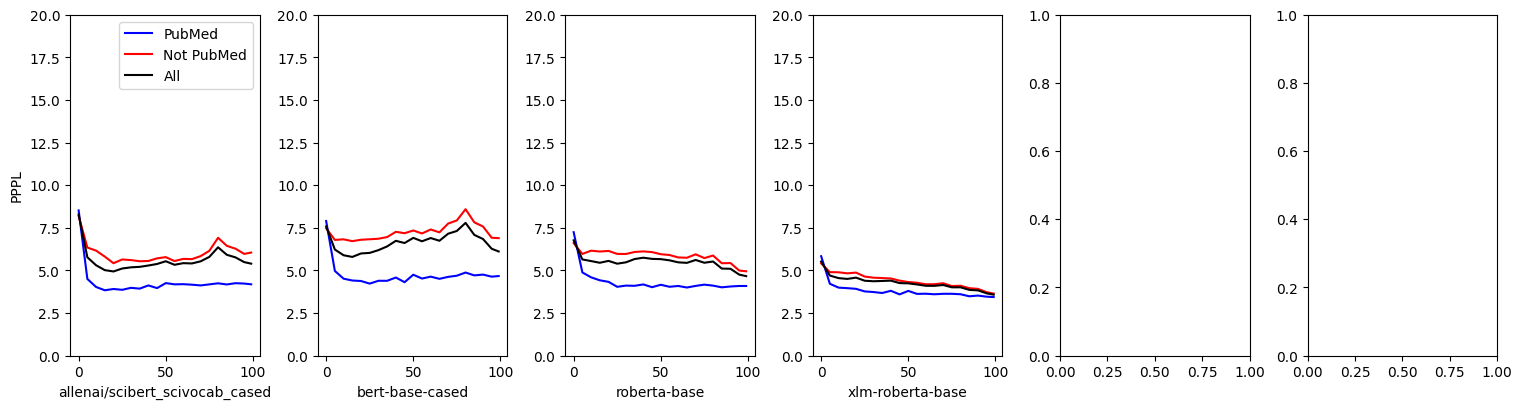

In [132]:
fig, ax = plt.subplots(1,6, figsize=(15,4))
fig.tight_layout()

colors = ['blue', 'red', 'black']

for i, (k,v) in enumerate(dfs.items()):

    arr = model_nps[k]
    
    pubmed_ids = v[(v['has_pubmed'] == True) | (v['has_pubmedcentral'] == True)][['bin', 'local_id']]
    non_pubmed_ids = v[(v['has_pubmed'] == False) & (v['has_pubmedcentral'] == False)][['bin', 'local_id']]
    all_ids = v[['bin', 'local_id']]

    for j, (id_set, name) in enumerate(zip([pubmed_ids, non_pubmed_ids, all_ids], ['PubMed', 'Not PubMed', 'All'])):
    
        bins = id_set['bin'].unique()
        vals = np.zeros(bins.shape)
        
        for bin_idx, bin in enumerate(bins):
            local_ids = id_set[id_set['bin'] == bin]['local_id']
            vals[bin_idx] = calculate_pppl(arr[bin, local_ids,:])

        ax[i].plot(bins, vals, label=name, color=colors[j])
        
    ax[i].set_ylim(bottom=0, top=20)
    ax[i].set_xlabel(k)
ax[0].set_ylabel('PPPL')
ax[0].legend()

In [156]:
print(f"{'Model':35s}\t{'Num PubMed Central Abstracts'}\t{'Num PubMed Abstracts'}\t{'Num Total Abstracts'}\t{'Intersection'}")
for i, (k,v) in enumerate(dfs.items()):
    print(f"{k:35s}\t{v['has_pubmedcentral'].sum():20d}\t{v['has_pubmed'].sum():20d}\t{len(v):19d}\t{((v['has_pubmed'] == True) & (v['has_pubmedcentral'] == True)).sum():20d}")

Model                              	Num PubMed Central Abstracts	Num PubMed Abstracts	Num Total Abstracts	Intersection
allenai/scibert_scivocab_cased     	                4244	               20561	              97413	                3954
bert-base-cased                    	                4266	               20747	              98168	                3976
roberta-base                       	                4251	               20620	              97587	                3962
xlm-roberta-base                   	                4273	               20838	              98157	                3983


In [157]:
for i, (k,v) in enumerate(dfs.items()):
    print(k)
    print(v.groupby('bin')['has_pubmed'].sum() / v.groupby('bin').size(), end='\n\n')

allenai/scibert_scivocab_cased
bin
0     0.229180
5     0.273766
10    0.350666
15    0.345459
20    0.281714
25    0.254428
30    0.223842
35    0.173127
40    0.158785
45    0.157723
50    0.134499
55    0.140026
60    0.147341
65    0.146305
70    0.152564
75    0.151230
80    0.171258
85    0.191508
90    0.213220
95    0.233396
99    0.307118
dtype: float64

bert-base-cased
bin
0     0.229677
5     0.274723
10    0.352929
15    0.343316
20    0.281975
25    0.254973
30    0.223823
35    0.172421
40    0.157838
45    0.158134
50    0.135263
55    0.140048
60    0.148054
65    0.146471
70    0.152751
75    0.151323
80    0.171513
85    0.190284
90    0.213786
95    0.233914
99    0.307374
dtype: float64

roberta-base
bin
0     0.229575
5     0.274600
10    0.352584
15    0.344442
20    0.282095
25    0.253818
30    0.223550
35    0.173014
40    0.158500
45    0.158306
50    0.135432
55    0.139752
60    0.147404
65    0.145780
70    0.152322
75    0.151522
80    0.170960
85    0.191